**Dog breath video**

| Video ID      | Location |
| ----------- | ----------- |
| dog000      | /content/drive/MyDrive/out/good/3-26-22 Dog_Video_GEB-harness_NonCon__14:52__15:49__ Petting on Back with Dog on Table.mp4       |
| dog001   | /content/drive/MyDrive/out/good/3-26-22 Dog_Video_GEB-harness_NonCon__27 22__28 41__ Dog Sitting on Table.mp4        |
| dog002   | /content/drive/MyDrive/out/good/3-26-22 Dog_Video_GEB-harness_NonCon__28 58__30 05__ Dog Sitting on Table.mp4       |
| dog003   | /content/drive/MyDrive/out/good/3-27-22 Dog_Video_GEB-harness_NonCon__15 55__17 00__ Deep Breaths with Dog on Table.mp4        |
| dog101   | /content/drive/MyDrive/out/good/IMG_0230.MOV        |
| dog102   | /content/drive/MyDrive/out/good/IMG_0231.MOV       |
| dog103   | /content/drive/MyDrive/out/good/IMG_0232.MOV        |

In [1]:
vid_path = '/home/mrahman7/Documents/ratVideos/rat001.MOV'
vid_id = 'rat001'

In [7]:
vid_path = '/home/mrahman7/Documents/ratVideos/rat002.MOV'
vid_id = 'rat002'

In [ ]:
vid_path = '/home/mrahman7/Documents/ratVideos/rat003.MOV'
vid_id = 'rat003'

In [1]:
vid_path = '/home/mrahman7/Documents/ratVideos/rat004.MOV'
vid_id = 'rat004'

In [2]:
vid_path = '/home/mrahman7/Documents/ratVideos/rat005.MOV'
vid_id = 'rat005'

In [1]:
!ls
%cd 'GMA'

 GMA  'GMA prediction.ipynb'
/home/mrahman7/Documents/HR_BR_project/gmaProject/GMA


In [6]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 542.5 kB/s eta 0:00:000:01


In [2]:

import sys
print(sys.path)
sys.path.append('core')

from PIL import Image
import argparse
import os
import numpy as np
import torch
import imageio

from network import RAFTGMA

import datasets
from utils import flow_viz
from utils import frame_utils

from utils.utils import InputPadder, forward_interpolate

['/home/mrahman7/Downloads/pycharm-2022.2.1/plugins/python/helpers-pro/jupyter_debug', '/home/mrahman7/Downloads/pycharm-2022.2.1/plugins/python/helpers/pydev', '/home/mrahman7/Documents/HR_BR_project/gmaProject', '/home/mrahman7/Documents/HR_BR_project/gmaProject', '/home/mrahman7/anaconda3/envs/amtc/lib/python38.zip', '/home/mrahman7/anaconda3/envs/amtc/lib/python3.8', '/home/mrahman7/anaconda3/envs/amtc/lib/python3.8/lib-dynload', '', '/home/mrahman7/anaconda3/envs/amtc/lib/python3.8/site-packages']


*The following function calculates Optical Flow vector(s) on **dog breath video segments** with log (debugging purpose)*


*   Input image shape
*   Padded image sahpe before passing to the GMA network
*   OF vector shape
*   Value range of OF image, OF vector and images



In [14]:
import cv2
import torch
import numpy as np
cap = None
#cap = cv2.VideoCapture(vid_path)
#cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
test_id = 0

@torch.no_grad()
def create_sintel_submission_vis(model, warm_start=False, output_path='sintel_submission'):
    """ Create submission for the Sintel leaderboard """
    global cap, test_id
    model.eval()
    for dstype in ['try0']:
        print(dstype)
        flow_prev, sequence_prev = None, None
        while (cap.isOpened() and test_id<5):
            cap.set(cv2.CAP_PROP_POS_FRAMES, test_id*60) # 2 second gap
            print(test_id)
            ret, img = cap.read()
            if ret == False:
                break
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
            print('processing new frame')
            print(img.shape)
            img = torch.from_numpy(img).permute(2, 0, 1).float() # HxWxC to CxHxW
            print(img.shape)
            if test_id==0:
                image1 = img
                padder = InputPadder(image1.shape)
                image1 = padder.pad(image1[None].to(f'cuda:{model.device_ids[0]}'))[0]
                test_id = 1
                continue
            else:
                image2 = img
                test_id += 1
            frame = cap.get(cv2.CAP_PROP_POS_FRAMES)-1
            sequence = 'vid0'
            #image1, image2, (sequence, frame) = test_dataset[test_id]
            if sequence != sequence_prev:
                flow_prev = None
            #padder = InputPadder(image2.shape)
            print('img shape',image2.shape)
            image2 = padder.pad(image2[None].to(f'cuda:{model.device_ids[0]}'))[0]
            print('img shape (padded)',image2.shape)
            print('img max',max(image2.reshape(-1)))

            flow_low, flow_pr = model.module(image1, image2, iters=32, flow_init=flow_prev, test_mode=True)
            flow = padder.unpad(flow_pr[0]).permute(1, 2, 0).cpu().numpy()
            print('flow shape',flow.shape)
            print('flow max',max(flow.reshape(-1)))
            print('flow min',min(flow.reshape(-1)))

            # Visualizations
            flow_img = flow_viz.flow_to_image(flow)
            print('flow img max',max(flow_img.reshape(-1)))
            image = Image.fromarray(flow_img)
            if not os.path.exists(f'vis_test/RAFT/{dstype}/'):
                os.makedirs(f'vis_test/RAFT/{dstype}/flow')

            if not os.path.exists(f'vis_test/ours/{dstype}/'):
                os.makedirs(f'vis_test/ours/{dstype}/flow')

            if not os.path.exists(f'vis_test/gt/{dstype}/'):
                os.makedirs(f'vis_test/gt/{dstype}/image')

            # image.save(f'vis_test/ours/{dstype}/flow/{test_id}.png')
            image.save(f'vis_test/RAFT/{dstype}/flow/{test_id}.png')
            imageio.imwrite(f'vis_test/gt/{dstype}/image/{test_id}.png', image1[0].cpu().permute(1, 2, 0).numpy())
            if warm_start:
                flow_prev = forward_interpolate(flow_low[0])[None].cuda()

            output_dir = os.path.join(output_path, dstype, sequence)
            output_file = os.path.join(output_dir, 'frame%04d.flo' % (frame+1))

            if not os.path.exists(output_dir):
                os.makedirs(output_dir)

            frame_utils.writeFlow(output_file, flow)
            sequence_prev = sequence
            image1 = image2

*The following function calculates Optical Flow vector(s) on **dog breath video segments** without log (run mode)*

In [3]:
import cv2
import torch
import numpy as np
cap = None
#cap = cv2.VideoCapture(vid_path)
#cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
test_id = 0
import time

@torch.no_grad()
def create_sintel_submission_vis(model, warm_start=False, global_ref=False, output_path='sintel_submission'):
    """ Create submission for the Sintel leaderboard """
    global cap, test_id, vid_id
    model.eval()
    for dstype in [vid_id]:
        if warm_start:
            dstype = dstype + '_warm'
        if global_ref:
            dstype = dstype + '_global'
        print(dstype)
        dur = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        flow_prev, sequence_prev = None, None
        t_start = time.time()
        while (cap.isOpened()):
            #cap.set(cv2.CAP_PROP_POS_FRAMES, test_id*60) # 2 second gap
            #print(test_id)
            ret, img = cap.read()
            if ret == False:
                break
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (0,0), fx=0.25, fy=0.25) # rat videos
            #img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
            #img = img[270:540,240:720] dog001
            #img = img[20:340, 50:400] #face001
            #img = img[360:540, 240:720] #dog051
            #print('processing new frame')
            #print(img.shape)
            img = torch.from_numpy(img).permute(2, 0, 1).float() # HxWxC to CxHxW
            #print(img.shape)
            if test_id==0:
                image1 = img
                padder = InputPadder(image1.shape)
                image1 = padder.pad(image1[None].to(f'cuda:{model.device_ids[0]}'))[0]
                test_id = 1
                continue
            else:
                image2 = img
                test_id += 1
            frame = cap.get(cv2.CAP_PROP_POS_FRAMES)-1
            sequence = 'vid0'
            #image1, image2, (sequence, frame) = test_dataset[test_id]
            if sequence != sequence_prev:
                flow_prev = None
            #padder = InputPadder(image2.shape)
            #print('img shape',image2.shape)
            image2 = padder.pad(image2[None].to(f'cuda:{model.device_ids[0]}'))[0]
            #print('img shape (padded)',image2.shape)
            #print('img max',max(image2.reshape(-1)))

            flow_low, flow_pr = model.module(image1, image2, iters=32, flow_init=flow_prev, test_mode=True)
            flow = padder.unpad(flow_pr[0]).permute(1, 2, 0).cpu().numpy()
            #print('flow shape',flow.shape)
            #print('flow max',max(flow.reshape(-1)))

            # Visualizations
            flow_img = flow_viz.flow_to_image(flow)
            #print('flow img max',max(flow_img.reshape(-1)))
            image = Image.fromarray(np.uint8(flow_img))
            if not os.path.exists(f'vis_test/RAFT/{dstype}/'):
                os.makedirs(f'vis_test/RAFT/{dstype}/flow')

            if not os.path.exists(f'vis_test/ours/{dstype}/'):
                os.makedirs(f'vis_test/ours/{dstype}/flow')

            if not os.path.exists(f'vis_test/gt/{dstype}/'):
                os.makedirs(f'vis_test/gt/{dstype}/image')

            # image.save(f'vis_test/ours/{dstype}/flow/{test_id}.png')
            #image.save(f'vis_test/RAFT/{dstype}/flow/{test_id}.png')
            #imageio.imwrite(f'vis_test/gt/{dstype}/image/{test_id}.png', image1[0].cpu().permute(1, 2, 0).numpy().astype(np.uint8))
            if warm_start:
                flow_prev = forward_interpolate(flow_low[0])[None].cuda()

            output_dir = os.path.join(output_path, dstype, sequence)
            output_file = os.path.join(output_dir, 'frame%04d.flo' % (frame+1))

            if not os.path.exists(output_dir):
                os.makedirs(output_dir)

            frame_utils.writeFlow(output_file, flow)
            sequence_prev = sequence
            if not global_ref:
                image1 = image2

            if test_id % 300 == 0:
                print('Processing frame {} out of {}'.format(test_id, int(dur)))
                remaining_time = (time.time() - t_start) * (dur / (test_id + 1) - 1)
                print('Remaining time: %d mins %d secs' % (remaining_time / 60, remaining_time % 60))

*The following code is the **main entry point** of running the above/below functions.*

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', default='checkpoints/gma-sintel.pth', help="restore checkpoint")
parser.add_argument('--dataset', default='sintel', help="dataset for evaluation")
parser.add_argument('--iters', type=int, default=12)
parser.add_argument('--num_heads', default=1, type=int,
                    help='number of heads in attention and aggregation')
parser.add_argument('--position_only', default=False, action='store_true',
                    help='only use position-wise attention')
parser.add_argument('--position_and_content', default=False, action='store_true',
                    help='use position and content-wise attention')
parser.add_argument('--mixed_precision', default=True, help='use mixed precision')
parser.add_argument('--model_name')

# Ablations
parser.add_argument('--replace', default=False, action='store_true',
                    help='Replace local motion feature with aggregated motion features')
parser.add_argument('--no_alpha', default=False, action='store_true',
                    help='Remove learned alpha, set it to 1')
parser.add_argument('--no_residual', default=False, action='store_true',
                    help='Remove residual connection. Do not add local features with the aggregated features.')

args = parser.parse_args("") # "" as its jupyter notebook

model = torch.nn.DataParallel(RAFTGMA(args))
model.load_state_dict(torch.load(args.model))

model.cuda()
model.eval()

vids = ['rat004', 'rat005']

for vid in vids:

    vid_path = '/home/mrahman7/Documents/ratVideos/' + vid + '.MOV'
    vid_id = vid
    test_id = 0

    #cap.release()
    if not os.path.exists(vid_path):
        print('incorrect video path')
        print(vid_path)
    cap = cv2.VideoCapture(vid_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    if not cap.isOpened():
        print('cap closed')
    else:
        print('cap open')
    # create_sintel_submission(model, warm_start=True)
    create_sintel_submission_vis(model, warm_start=False, global_ref=True)
    # create_kitti_submission(model)
    # create_kitti_submission_vis(model)

cap open
rat004_global
Processing frame 300 out of 5170
Remaining time: 49 mins 40 secs
Processing frame 600 out of 5170
Remaining time: 46 mins 45 secs
Processing frame 900 out of 5170
Remaining time: 43 mins 47 secs
Processing frame 1200 out of 5170
Remaining time: 40 mins 44 secs
Processing frame 1500 out of 5170
Remaining time: 37 mins 39 secs
Processing frame 1800 out of 5170
Remaining time: 34 mins 34 secs
Processing frame 2100 out of 5170
Remaining time: 31 mins 32 secs
Processing frame 2400 out of 5170
Remaining time: 28 mins 26 secs
Processing frame 2700 out of 5170
Remaining time: 25 mins 21 secs
Processing frame 3000 out of 5170
Remaining time: 22 mins 17 secs
Processing frame 3300 out of 5170
Remaining time: 19 mins 12 secs
Processing frame 3600 out of 5170
Remaining time: 16 mins 7 secs
Processing frame 3900 out of 5170
Remaining time: 13 mins 2 secs
Processing frame 4200 out of 5170
Remaining time: 9 mins 57 secs
Processing frame 4500 out of 5170
Remaining time: 6 mins 52

*The following function calculates Optical Flow vector(s) on **Sintel test dataset** with log (debugging purpose)*

The sintel test dataset is located on *`GMA/MPI-Sintel-testing`* folder


*   Input image shape
*   Padded image sahpe before passing to the GMA network
*   OF vector shape
*   Value range of OF image, OF vector and images

In [ ]:
import numpy as np
@torch.no_grad()
def create_sintel_submission_vis(model, warm_start=False, output_path='sintel_submission'):
    """ Create submission for the Sintel leaderboard """
    model.eval()
    for dstype in ['clean', 'final']:
        test_dataset = datasets.MpiSintel(split='test', aug_params=None, dstype=dstype)

        flow_prev, sequence_prev = None, None
        for test_id in range(len(test_dataset)):
            image1, image2, (sequence, frame) = test_dataset[test_id]
            # frame starts from 0 increases irrespective of sequence change
            # afaik frame is same as test_id
            # sequence change is basically video change
            if frame>3:
                break
            if sequence != sequence_prev:
                flow_prev = None
            print(sequence)
            padder = InputPadder(image1.shape)
            print('img shape',image1.shape)
            image1, image2 = padder.pad(image1[None].to(f'cuda:{model.device_ids[0]}'), image2[None].to(f'cuda:{model.device_ids[0]}'))
            print('img shape (padded)',image1.shape)
            print('img max',max(image1.reshape(-1)))

            flow_low, flow_pr = model.module(image1, image2, iters=32, flow_init=flow_prev, test_mode=True)
            flow = padder.unpad(flow_pr[0]).permute(1, 2, 0).cpu().numpy()
            print('flow shape',flow.shape)
            print('flow max',max(flow.reshape(-1)))

            # Visualizations
            flow_img = flow_viz.flow_to_image(flow)
            print('flow img max',max(flow_img.reshape(-1)))
            image = Image.fromarray(np.uint8(flow_img))
            if not os.path.exists(f'vis_test/RAFT/{dstype}/'):
                os.makedirs(f'vis_test/RAFT/{dstype}/flow')

            if not os.path.exists(f'vis_test/ours/{dstype}/'):
                os.makedirs(f'vis_test/ours/{dstype}/flow')

            if not os.path.exists(f'vis_test/gt/{dstype}/'):
                os.makedirs(f'vis_test/gt/{dstype}/image')

            # image.save(f'vis_test/ours/{dstype}/flow/{test_id}.png')
            image.save(f'vis_test/RAFT/{dstype}/flow/{test_id}.png') # image name without +1
            imageio.imwrite(f'vis_test/gt/{dstype}/image/{test_id}.png', image1[0].cpu().permute(1, 2, 0).numpy())
            if warm_start:
                flow_prev = forward_interpolate(flow_low[0])[None].cuda()

            output_dir = os.path.join(output_path, dstype, sequence)
            output_file = os.path.join(output_dir, 'frame%04d.flo' % (frame+1)) # frame+1 used as image name

            if not os.path.exists(output_dir):
                os.makedirs(output_dir)

            frame_utils.writeFlow(output_file, flow)
            sequence_prev = sequence

*Dog video play*

300.0


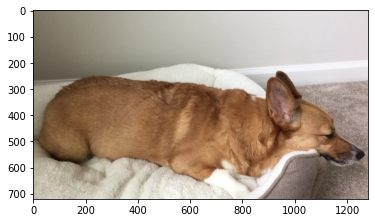

In [7]:
import cv2
import time
import matplotlib.pyplot as plt
from google.colab import output
cap1 = cv2.VideoCapture(vid_path)

#cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
n = 0

while (cap1.isOpened() and n<5):
    ret, img = cap1.read()
    if ret == False:
        break
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    n += 1
    cap1.set(cv2.CAP_PROP_POS_FRAMES, n*60)
    output.clear()
    print(cap1.get(cv2.CAP_PROP_POS_FRAMES))
    plt.imshow(img)
    plt.show()

    plt.pause(1)
cap1.release()

In [6]:
!git clone https://github.com/zacjiang/GMA.git

Cloning into 'GMA'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 82 (delta 7), reused 2 (delta 2), pack-reused 68ng objects:  21% (18/82), 3.52 MiB | 893.00 KiB/sUnpacking objects:  21% (18/82), 5.31 MiB | 969.00 KiB/sUnpacking objects:  21% (18/82), 7.10 MiB | 907.00 KiB/sUnpacking objects:  21% (18/82), 8.94 MiB | 909.00 KiB/sUnpacking objects:  21% (18/82), 10.80 MiB | 933.00 KiB/sUnpacking objects:  21% (18/82), 12.61 MiB | 926.00 KiB/sUnpacking objects:  21% (18/82), 14.44 MiB | 924.00 KiB/sUnpacking objects:  21% (18/82), 16.25 MiB | 924.00 KiB/sUnpacking objects:  21% (18/82), 18.07 MiB | 924.00 KiB/sUnpacking objects:  21% (18/82), 19.89 MiB | 924.00 KiB/sUnpacking objects:  23% (19/82), 20.79 MiB | 923.00 KiB/sUnpacking objects:  23% (19/82), 23.48 MiB | 924.00 KiB/sUnpacking objects:  23% (19/82), 25.29 MiB | 926.00 KiB/sUnpacking objects:  23% (19/82), 27.08 MiB | 919.00 